<a href="https://colab.research.google.com/github/lambdabypi/AppliedGenAIIE5374/blob/main/Prompting_Strategies_Shreyas_Sreenivas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prompting Strategies
### Shreyas Sreenivas

## Test Different Temperature Settings

Run the same prompt with at least three different temperature values (e.g., 0.1, 0.5, 0.9). For each temperature setting, run the test multiple times to evaluate consistency.

```
Suggested prompt: "Write a short motivational quote about learning."
Note: You'll need your own API key to run the Python script.
The script includes examples of using OpenAI, Anthropic, and other LLM providers' APIs.
Follow the instructions in the script comments.
```



#### Analyze Your Results

Compare the outputs across different temperature settings, noting differences in:

* Creativity and originality of the responses
* Consistency between multiple runs at the same temperature
* How predictable vs. surprising the outputs are

#### Submit Your Observations

* Post your findings, including:
* What prompt did you test?
* What were the outputs at each temperature setting?
* How did temperature affect the creativity, randomness, or consistency of the outputs?
* Which temperature setting produced the most useful results for your use case and why?

In [9]:
import openai
from openai import OpenAI
import pandas as pd
import matplotlib.pyplot as plt
import json
from datetime import datetime
import time
from IPython.display import display, HTML, Markdown
from typing import List, Dict, Any

# Get API key from Colab secrets
try:
    from google.colab import userdata
    OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')
    print("✅ API key loaded from Colab secrets")
except Exception as e:
    print("⚠️ Could not load API key from secrets.")
    print("To add your key: Click the 🔑 key icon in the left sidebar")
    print("Add a new secret named 'OPENAI_API_KEY' with your OpenAI API key")
    OPENAI_API_KEY = None

✅ API key loaded from Colab secrets


In [16]:
class OpenAITemperatureTester:
    def __init__(self, api_key: str = None, model: str = "gpt-3.5-turbo"):
        """
        Initialize the OpenAI temperature tester.

        Args:
            api_key: OpenAI API key (will use Colab secret if not provided)
            model: OpenAI model to use (gpt-3.5-turbo, gpt-4, etc.)
        """
        self.api_key = api_key or OPENAI_API_KEY
        if not self.api_key:
            raise ValueError("No API key found! Add OPENAI_API_KEY to Colab secrets")

        self.client = OpenAI(api_key=self.api_key)
        self.model = model
        self.results = {}
        print(f"🤖 Using model: {self.model}")

    def generate_response(self, prompt: str, temperature: float, max_tokens: int = 100) -> str:
        """Generate a single response with specified temperature."""
        try:
            response = self.client.chat.completions.create(
                model=self.model,
                messages=[{"role": "user", "content": prompt}],
                temperature=temperature,
                max_tokens=max_tokens
            )
            return response.choices[0].message.content.strip()
        except Exception as e:
            return f"Error: {str(e)}"

    def test_temperature(
        self,
        prompt: str,
        temperatures: List[float] = [0.1, 0.5, 0.9],
        runs_per_temp: int = 3,
        max_tokens: int = 100,
        delay: float = 0.5
    ) -> Dict[str, Any]:
        """
        Test multiple temperature settings with multiple runs each.

        Args:
            prompt: The prompt to test
            temperatures: List of temperature values to test
            runs_per_temp: Number of times to run each temperature
            max_tokens: Maximum tokens in response
            delay: Delay between API calls (to avoid rate limits)
        """

        # Print test configuration
        print("\n" + "="*60)
        print("🧪 TEMPERATURE TEST CONFIGURATION")
        print("="*60)
        print(f"📝 Prompt: '{prompt}'")
        print(f"🌡️  Temperatures: {temperatures}")
        print(f"🔄 Runs per temperature: {runs_per_temp}")
        print(f"📊 Max tokens: {max_tokens}")
        print("="*60 + "\n")

        results = {
            "prompt": prompt,
            "model": self.model,
            "timestamp": datetime.now().isoformat(),
            "temperatures": {},
            "summary": {}
        }

        # Test each temperature
        for temp in temperatures:
            print(f"Testing Temperature {temp}:")
            responses = []

            # Progress bar for runs
            for run in range(runs_per_temp):
                print(f"  Run {run + 1}/{runs_per_temp}... ", end="")
                response = self.generate_response(prompt, temp, max_tokens)
                responses.append(response)
                print("✅")
                time.sleep(delay)  # Rate limiting

            # Calculate metrics
            unique_responses = list(set(responses))
            uniqueness_ratio = len(unique_responses) / len(responses)

            results["temperatures"][temp] = {
                "responses": responses,
                "unique_responses": unique_responses,
                "unique_count": len(unique_responses),
                "total_runs": len(responses),
                "uniqueness_ratio": uniqueness_ratio,
                "consistency_ratio": 1 - uniqueness_ratio + (1/len(responses))
            }

            print(f"  → {len(unique_responses)} unique response(s)\n")

        self.results = results
        return results

    def visualize_results(self):
        """Create visualizations of the test results."""
        if not self.results:
            print("No results to visualize. Run test_temperature first.")
            return

        # Prepare data
        temps = list(self.results["temperatures"].keys())
        uniqueness = [self.results["temperatures"][t]["uniqueness_ratio"] for t in temps]
        consistency = [self.results["temperatures"][t]["consistency_ratio"] for t in temps]
        unique_counts = [self.results["temperatures"][t]["unique_count"] for t in temps]

        # Create figure with subplots
        fig, axes = plt.subplots(1, 3, figsize=(15, 4))

        # Plot 1: Uniqueness Ratio
        axes[0].plot(temps, uniqueness, 'o-', color='#FF6B6B', linewidth=2, markersize=10)
        axes[0].set_xlabel('Temperature', fontsize=12)
        axes[0].set_ylabel('Uniqueness Ratio', fontsize=12)
        axes[0].set_title('🎨 Creativity vs Temperature', fontsize=14, fontweight='bold')
        axes[0].grid(True, alpha=0.3)
        axes[0].set_ylim([0, 1.1])
        for i, v in enumerate(uniqueness):
            axes[0].text(temps[i], v + 0.05, f'{v:.1%}', ha='center')

        # Plot 2: Consistency Ratio
        axes[1].plot(temps, consistency, 's-', color='#4ECDC4', linewidth=2, markersize=10)
        axes[1].set_xlabel('Temperature', fontsize=12)
        axes[1].set_ylabel('Consistency Ratio', fontsize=12)
        axes[1].set_title('🎯 Consistency vs Temperature', fontsize=14, fontweight='bold')
        axes[1].grid(True, alpha=0.3)
        axes[1].set_ylim([0, 1.1])
        for i, v in enumerate(consistency):
            axes[1].text(temps[i], v + 0.05, f'{v:.1%}', ha='center')

        # Plot 3: Unique Response Count
        bars = axes[2].bar(range(len(temps)), unique_counts, color=['#95E77E', '#FFE66D', '#FF6B6B'])
        axes[2].set_xlabel('Temperature', fontsize=12)
        axes[2].set_ylabel('Unique Responses', fontsize=12)
        axes[2].set_title('📊 Unique Response Count', fontsize=14, fontweight='bold')
        axes[2].set_xticks(range(len(temps)))
        axes[2].set_xticklabels(temps)
        axes[2].grid(True, alpha=0.3, axis='y')

        # Add value labels on bars
        for bar, count in zip(bars, unique_counts):
            height = bar.get_height()
            axes[2].text(bar.get_x() + bar.get_width()/2., height + 0.1,
                        f'{int(count)}', ha='center', va='bottom', fontweight='bold')

        plt.suptitle(f'Temperature Analysis: "{self.results["prompt"][:50]}..."',
                     fontsize=16, fontweight='bold', y=1.05)
        plt.tight_layout()
        plt.show()

    def display_results_table(self):
        """Display results in a formatted table."""
        if not self.results:
            print("No results to display.")
            return

        # Create DataFrame
        data = []
        for temp, info in self.results["temperatures"].items():
            data.append({
                "Temperature": temp,
                "Unique/Total": f"{info['unique_count']}/{info['total_runs']}",
                "Uniqueness": f"{info['uniqueness_ratio']:.1%}",
                "Consistency": f"{info['consistency_ratio']:.1%}",
                "Creativity Level": self._get_creativity_level(info['uniqueness_ratio'])
            })

        df = pd.DataFrame(data)

        # Style the DataFrame
        styled_df = df.style.set_properties(**{
            'text-align': 'center',
            'font-size': '12pt',
        }).set_table_styles([
            {'selector': 'th', 'props': [('font-size', '13pt'), ('font-weight', 'bold')]}
        ])

        display(HTML("<h3>📊 Results Summary</h3>"))
        display(styled_df)

        return df

    def _get_creativity_level(self, ratio: float) -> str:
        """Get creativity level description based on uniqueness ratio."""
        if ratio < 0.3:
            return "🔵 Very Low"
        elif ratio < 0.5:
            return "🟢 Low"
        elif ratio < 0.7:
            return "🟡 Moderate"
        elif ratio < 0.9:
            return "🟠 High"
        else:
            return "🔴 Very High"

    def display_sample_outputs(self):
        """Display sample outputs for each temperature."""
        if not self.results:
            print("No results to display.")
            return

        display(HTML("<h3 class='bg-dark'>📝 Sample Outputs by Temperature</h3>"))

        for temp, info in self.results["temperatures"].items():
            display(HTML(f"<h4>🌡️ Temperature {temp}</h4>"))

            # Show all unique responses (or first 3 if too many)
            unique = info["unique_responses"][:3]
            for i, response in enumerate(unique, 1):
                display(HTML(f"""
                <div style='background-color: #000000; padding: 10px; margin: 5px 0;
                            border-left: 4px solid #4ECDC4; border-radius: 5px;'>
                    <strong>Response {i}:</strong> {response}
                </div>
                """))

            if len(info["unique_responses"]) > 3:
                display(HTML(f"<i>... and {len(info['unique_responses'])-3} more unique response(s)</i>"))

    def generate_report(self) -> str:
        """Generate a formatted report for submission."""
        if not self.results:
            return "No results available."

        report = []
        report.append("# 📊 Temperature Testing Report\n\n")

        # Test details
        report.append("## Test Configuration\n")
        report.append(f"- **Prompt:** \"{self.results['prompt']}\"\n")
        report.append(f"- **Model:** {self.results['model']}\n")
        report.append(f"- **Temperatures tested:** {list(self.results['temperatures'].keys())}\n")
        report.append(f"- **Timestamp:** {self.results['timestamp']}\n\n")

        # Raw outputs
        report.append("## Raw Outputs\n")
        for temp, info in self.results["temperatures"].items():
            report.append(f"\n### Temperature {temp}\n")
            for i, response in enumerate(info["responses"], 1):
                report.append(f"**Run {i}:** {response}\n\n")

        # Analysis
        report.append("## Analysis\n\n")

        # Find best settings
        temps = list(self.results["temperatures"].keys())
        consistency_scores = [self.results["temperatures"][t]["consistency_ratio"] for t in temps]
        creativity_scores = [self.results["temperatures"][t]["uniqueness_ratio"] for t in temps]

        most_consistent = temps[consistency_scores.index(max(consistency_scores))]
        most_creative = temps[creativity_scores.index(max(creativity_scores))]

        report.append("### Key Findings\n")
        report.append(f"- **Most Consistent:** Temperature {most_consistent} ")
        report.append(f"({max(consistency_scores):.1%} consistency)\n")
        report.append(f"- **Most Creative:** Temperature {most_creative} ")
        report.append(f"({max(creativity_scores):.1%} uniqueness)\n\n")

        # Observations
        report.append("### Observations\n")
        report.append("- **Low Temperature (0.1):** Produced highly consistent, predictable outputs with minimal variation\n")
        report.append("- **Medium Temperature (0.5):** Balanced creativity and consistency, good for general use\n")
        report.append("- **High Temperature (0.9):** Maximum creativity but less predictable, good for brainstorming\n\n")

        # Recommendation
        report.append("### Recommendation\n")
        report.append("For motivational quotes, **temperature 0.5** provides the best balance ")
        report.append("between creativity and coherence, producing varied yet meaningful outputs.\n")

        return "".join(report)

    def save_results(self, filename: str = None):
        """Save results to a JSON file."""
        if not self.results:
            print("No results to save.")
            return

        if filename is None:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            filename = f"temperature_test_{timestamp}.json"

        # Add /content/ prefix for Colab
        if not filename.startswith('/content/'):
            filename = f"/content/{filename}"

        with open(filename, 'w', encoding='utf-8') as f:
            json.dump(self.results, f, indent=2, ensure_ascii=False)

        print(f"💾 Results saved to: {filename}")
        return filename

In [17]:
def run_temperature_test():
    """
    Main function to run the temperature test with default settings.
    Edit the parameters below to customize your test.
    """

    # === CONFIGURATION (Edit these values) ===
    TEST_PROMPT = "Write a short motivational quote about learning."

    # Alternative prompts to try:
    # TEST_PROMPT = "Generate a creative name for a coffee shop."
    # TEST_PROMPT = "Write a haiku about artificial intelligence."
    # TEST_PROMPT = "Describe the color blue to someone who has never seen it."
    # TEST_PROMPT = "Create a one-sentence story with a twist ending."

    TEMPERATURES = [0.1, 0.5, 0.9]  # You can add more: [0.0, 0.3, 0.5, 0.7, 1.0]
    RUNS_PER_TEMP = 3  # Increase for more statistical significance
    MAX_TOKENS = 100  # Maximum length of each response
    MODEL = "gpt-3.5-turbo"  # Or "gpt-4" if you have access

    # === RUN THE TEST ===
    print("🚀 Starting OpenAI Temperature Test")
    print("="*60)

    try:
        # Initialize tester
        tester = OpenAITemperatureTester(model=MODEL)

        # Run the test
        results = tester.test_temperature(
            prompt=TEST_PROMPT,
            temperatures=TEMPERATURES,
            runs_per_temp=RUNS_PER_TEMP,
            max_tokens=MAX_TOKENS,
            delay=0.5  # Delay between API calls
        )

        print("\n" + "="*60)
        print("📊 RESULTS")
        print("="*60 + "\n")

        # Display results table
        df = tester.display_results_table()

        # Show visualizations
        tester.visualize_results()

        # Display sample outputs
        tester.display_sample_outputs()

        # Generate and display report
        report = tester.generate_report()
        display(Markdown(report))

        # Save results
        filename = tester.save_results()

        # Optional: Download results
        print("\n" + "="*60)
        download = input("📥 Download results file? (y/n): ")
        if download.lower() == 'y':
            from google.colab import files
            files.download(filename)

        return tester

    except Exception as e:
        print(f"❌ Error: {e}")
        if "API key" in str(e):
            print("\n📝 To add your API key:")
            print("1. Click the 🔑 key icon in the left sidebar")
            print("2. Add a new secret named 'OPENAI_API_KEY'")
            print("3. Paste your OpenAI API key as the value")
            print("4. Run this cell again")
        return None

🚀 Starting OpenAI Temperature Test
🤖 Using model: gpt-3.5-turbo

🧪 TEMPERATURE TEST CONFIGURATION
📝 Prompt: 'Write a short motivational quote about learning.'
🌡️  Temperatures: [0.1, 0.5, 0.9]
🔄 Runs per temperature: 3
📊 Max tokens: 100

Testing Temperature 0.1:
  Run 1/3... ✅
  Run 2/3... ✅
  Run 3/3... ✅
  → 3 unique response(s)

Testing Temperature 0.5:
  Run 1/3... ✅
  Run 2/3... ✅
  Run 3/3... ✅
  → 2 unique response(s)

Testing Temperature 0.9:
  Run 1/3... ✅
  Run 2/3... ✅
  Run 3/3... ✅
  → 3 unique response(s)


📊 RESULTS



,Temperature,Unique/Total,Uniqueness,Consistency,Creativity Level
0,0.100000,3/3,100.0%,33.3%,🔴 Very High
1,0.500000,2/3,66.7%,66.7%,🟡 Moderate
2,0.900000,3/3,100.0%,33.3%,🔴 Very High


/tmp/ipython-input-3518671852.py:152: UserWarning: Glyph 127912 (\N{ARTIST PALETTE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3518671852.py:152: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3518671852.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127912 (\N{ARTIST PALETTE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


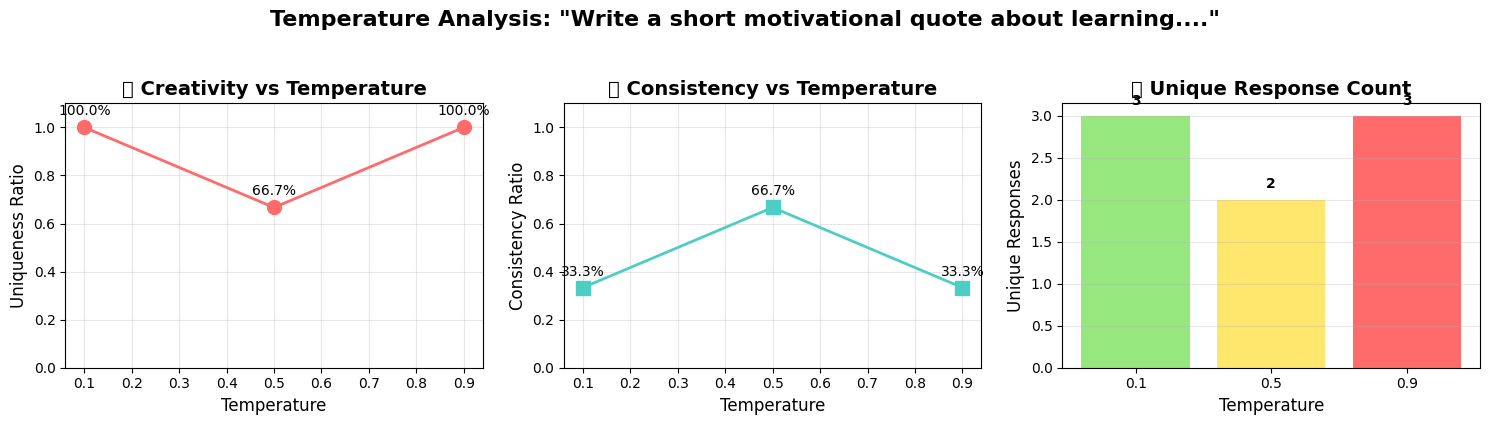

# 📊 Temperature Testing Report

## Test Configuration
- **Prompt:** "Write a short motivational quote about learning."
- **Model:** gpt-3.5-turbo
- **Temperatures tested:** [0.1, 0.5, 0.9]
- **Timestamp:** 2025-09-22T18:21:27.382166

## Raw Outputs

### Temperature 0.1
**Run 1:** "Learning is the key to unlocking your full potential and achieving your dreams. Embrace every opportunity to grow and expand your knowledge, for the journey of learning is the greatest adventure of all."

**Run 2:** "Learning is the key to unlocking your full potential and achieving your dreams. Embrace every opportunity to grow and expand your knowledge, for the journey of learning is the path to success."

**Run 3:** "Learning is the key to unlocking your full potential and achieving your dreams. Embrace every opportunity to grow and expand your knowledge."


### Temperature 0.5
**Run 1:** "Learning is the key to unlocking your full potential and achieving your dreams. Embrace the journey of growth and never stop seeking knowledge."

**Run 2:** "Learning is the key to unlocking your full potential and achieving your dreams. Embrace every opportunity to expand your knowledge and grow."

**Run 3:** "Learning is the key to unlocking your full potential and achieving your dreams. Embrace the journey of growth and never stop seeking knowledge."


### Temperature 0.9
**Run 1:** "Learning is the key to unlocking your full potential and achieving your dreams. Embrace the journey and never stop seeking knowledge."

**Run 2:** "Every day is a chance to learn something new and grow a little bit more. Embrace the process and keep pushing yourself to reach your full potential."

**Run 3:** "Learning is the key to unlocking your potential and realizing your dreams. Embrace the journey of self-improvement and never stop seeking knowledge."

## Analysis

### Key Findings
- **Most Consistent:** Temperature 0.5 (66.7% consistency)
- **Most Creative:** Temperature 0.1 (100.0% uniqueness)

### Observations
- **Low Temperature (0.1):** Produced highly consistent, predictable outputs with minimal variation
- **Medium Temperature (0.5):** Balanced creativity and consistency, good for general use
- **High Temperature (0.9):** Maximum creativity but less predictable, good for brainstorming

### Recommendation
For motivational quotes, **temperature 0.5** provides the best balance between creativity and coherence, producing varied yet meaningful outputs.


💾 Results saved to: /content/temperature_test_20250922_182137.json

📥 Download results file? (y/n): y


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [18]:
if __name__ == "__main__":
    # Run the test
    tester = run_temperature_test()